# Применение алгоритмов машинного обучения в Логико-информационной модели изучения влияния препаратов таргетной терапии на биологическую активность раковых клеток

## Подготовка к анализу 

In [58]:
# Библиотеки для вычислений и работы с данными
import pandas as pd
import numpy as np
import csv


# Библиотеки для отрисовки графиков
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотека для машинного обучения
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Библиотека для статистики
from scipy import stats

## Создание датасета 

### Пока данных мало датасет не нужен

## Data

In [59]:
test1 = pd.read_csv(r"C:\Users\nikol\Downloads\тест1.csv", on_bad_lines='skip')
test6 = pd.read_csv(r"C:\Users\nikol\Downloads\тест6.csv", on_bad_lines='skip')
test9 = pd.read_csv(r"C:\Users\nikol\Downloads\SN A700afhl Test 09 - Dec 12 12.12.17.csv", on_bad_lines='skip')
test10 = pd.read_csv(r"C:\Users\nikol\Downloads\SN A700afhl Test 10 - Dec 12 12.14.10.csv", on_bad_lines='skip')
test15 = pd.read_csv(r"C:\Users\nikol\Downloads\тест 15.csv", on_bad_lines='skip')

In [60]:
test15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6.00    399 non-null    float64
 1   2368    399 non-null    int64  
 2   0.11    399 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


In [61]:
test15.head()

,6.00,2368,0.11
0,6.93,2164,0.17
1,7.65,1341,0.23
2,8.26,945,0.30
3,8.80,663,0.36
4,9.27,457,0.42


## Линейная регрессия с градиентным спуском

In [62]:
class AnalyticLinearRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        # Добавляем колонку с единицами для учета смещения (bias term)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        # Вычисляем параметры модели с помощью нормального уравнения
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):

        # Добавляем колонку с единицами как в методе fit
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        # Возвращаем предсказания модели
        return X_b.dot(self.theta)

In [63]:
class GDLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, l1_ratio=0.5, l2_ratio=0.5, zeros_init=False):
        # инициализация параметров модели
        self.learning_rate = learning_rate # скорость обучения
        self.n_iterations = n_iterations # количество итераций
        self.l1_ratio = l1_ratio # коэффициент L1 регуляризации
        self.l2_ratio = l2_ratio # коэффициент L2 регуляризации
        self.weights = None # веса модели
        self.bias = None # смещение
        self.zeros_init = zeros_init # инициализация нулями в начале обучения
        self.loss_history = [] # история лоссов

    # Градиентный шаг для L1 регуляризации
    def _lasso_gradient(self):
        # np.sign возвращает знак числа (-1, 0, 1)
        # это штрафует большие веса и помогает в предотвращении переобучения
        return self.l1_ratio * np.sign(self.weights)

    # Градиентный шаг для L2 регуляризации
    def _ridge_gradient(self):
        # это штрафует большие веса квадратично и помогает в предотвращении переобучения
        return self.l2_ratio * self.weights

    # Вычисление градиента
    def _compute_gradient(self, X, y):
        # размер обучающей выборки, нужен для нормализации градиента, но не обязателен
        n = X.shape[0]
        # получаем предсказания модели
        y_pred = self.predict(X)
        # вычисляем градиент функции потерь по весам
        d_weights = (2 / n) * (X.T.dot(y_pred - y)) + self._lasso_gradient() + self._ridge_gradient()
        # вычисляем градиент функции потерь для смещения
        dbias = (2 / n) * np.sum(y_pred - y)
        return d_weights, dbias

    # Вычсиление сумарной ошибки на датасете
    def compute_loss(self, X, y):
        y_pred = self.predict(X)

        mse_loss = np.mean((y - y_pred)**2)
        lasso_term = self.l1_ratio * np.sum(np.abs(self.weights))
        ridge_term = self.l2_ratio * np.sum(self.weights**2)

        # Сумарный лосс состоит из всех частей
        loss = mse_loss + lasso_term + ridge_term

        return loss

    # Обучение модели
    def fit(self, X, y):
        # инициализируем веса и смещение случайными числаи из равномерного распределения
        self.weights = np.zeros(X.shape[1]) if self.zeros_init else np.random.rand(X.shape[1])
        self.bias = 0 if self.zeros_init else np.random.randn()

        # итерируемся заданное количество раз
        for _ in range(self.n_iterations):
            # print(self.weights)
            # вычисляем градиент
            d_weights, dbias = self._compute_gradient(X, y)
            # обновляем веса и смещение
            self.weights -= self.learning_rate * d_weights
            self.bias -= self.learning_rate * dbias

            # вычисляем финальный лосс, пишем в историю
            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

    # Предсказание
    def predict(self, X):
        # дот-продукт весов и признаков плюс смещение
        return X.dot(self.weights) + self.bias

## Линейная регрессия из sklearn

In [64]:
#Data set Preprocess data
dataframe = pd.read_csv(r"C:\Users\nikol\Downloads\тест 15.csv", on_bad_lines='skip')
print(dataframe.head())
#Git rid of the name of the animal
#And change the hunter/scavenger to 0/1

cleanup = {"Class": {"Primary Hunter" : 0, "Primary Scavenger": 1     }}
dataframe.replace(cleanup, inplace = True)
print(dataframe.head())
#array = dataframe.values
#Data splt
# Seperating the data into dependent and independent variables
X = dataframe.iloc[:,0:-1]

y = dataframe.iloc[:,-1]
print(X)
print(y)

   6.00  2368  0.11
0  6.93  2164  0.17
1  7.65  1341  0.23
2  8.26   945  0.30
3  8.80   663  0.36
4  9.27   457  0.42
   6.00  2368  0.11
0  6.93  2164  0.17
1  7.65  1341  0.23
2  8.26   945  0.30
3  8.80   663  0.36
4  9.27   457  0.42
      6.00  2368
0     6.93  2164
1     7.65  1341
2     8.26   945
3     8.80   663
4     9.27   457
..     ...   ...
394  35.85     0
395  35.88     0
396  35.91     0
397  35.94     0
398  35.97     0

[399 rows x 2 columns]
0       0.17
1       0.23
2       0.30
3       0.36
4       0.42
       ...  
394    24.13
395    24.19
396    24.25
397    24.31
398    24.37
Name: 0.11, Length: 399, dtype: float64


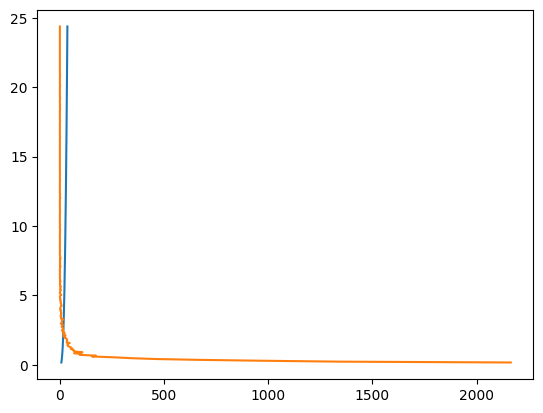

In [65]:
plt.plot(X, y)
plt.show()

## Обучение линейной регрессии

In [66]:
## В процессе

## Plots

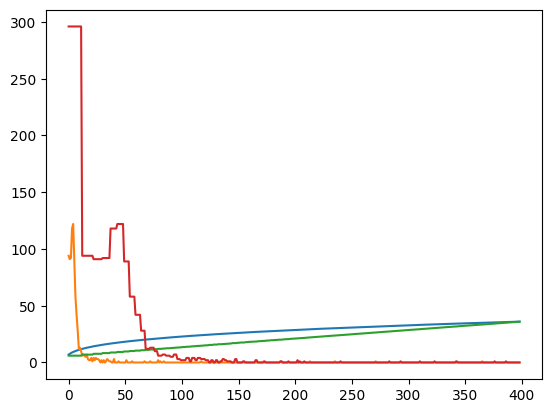

In [67]:
plt.plot(test1)
plt.show()

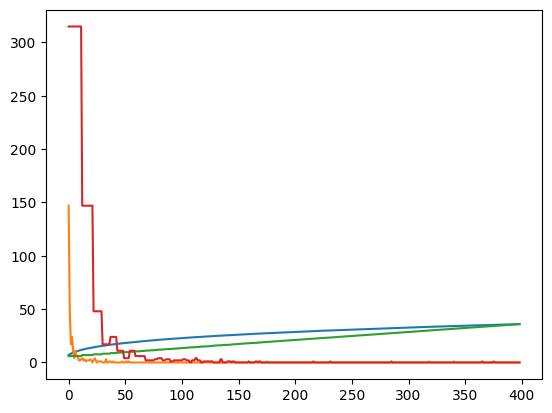

In [68]:
plt.plot(test6)
plt.show()

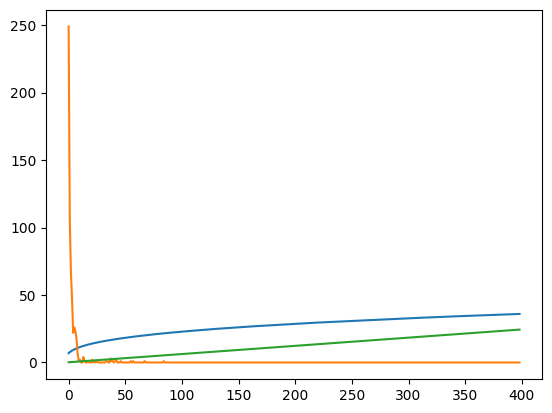

In [69]:
plt.plot(test9)
plt.show()

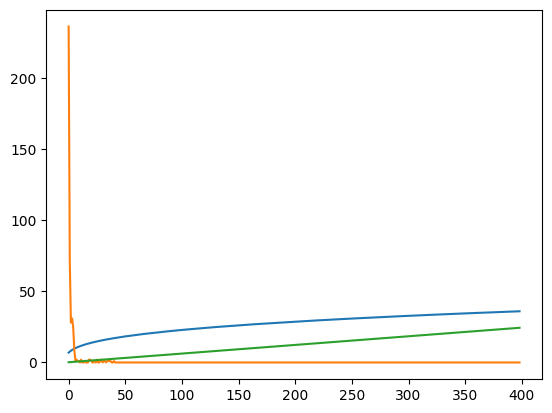

In [70]:
plt.plot(test10)
plt.show()

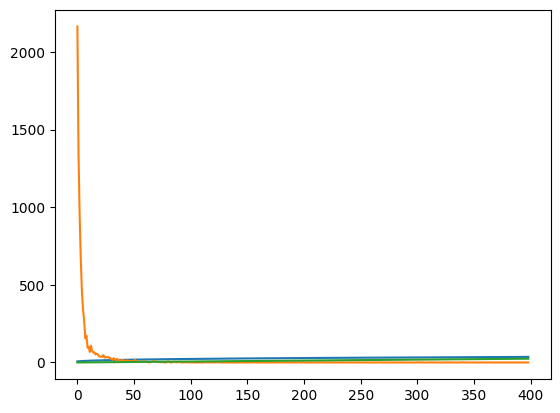

In [71]:
plt.plot(test15)
plt.show()